In [ ]:
# calibrate_smemp.ipynb
# Script to compare the properties derived using Specmath-emp on APF spectra to the properties reported in the Yee et al. 
# 2017 library. 
# Last modified 8/12/20 by Anna Zuckerman 
#
# Input: specmatch_results.csv, generated by running smemp_multifile.ipynb on the APF calibration target stars.
# Output: Plots comparing APF Specmatch and Yee catalog results. Calculation of RMS between the two.
#        No saved output currently.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.simbad import Simbad

In [13]:
# find HIP names of each star in order to compare the same stars
def get_HIPname(name):
    if name.startswith('HIP'):
            HIP_name = name
    else:      
        try:
            result_table = Simbad.query_objectids(name)
            alt_names = result_table.to_pandas()
            alt_names = alt_names.iloc[:,0].str.decode('utf-8') #gets rid of weird formatting
            HIP_name = alt_names[alt_names.str.contains("HIP")]
            if len(HIP_name) == 0:
                HIP_name = 'None'
                print(name + ' has no HIP name in SIMBAD') #this should never occur since only using stars with HIP names for finding overlap between apf and Yee
            elif len(HIP_name) == 1:
                HIP_name = str(HIP_name.iloc[0]) # makes it a string instead of dataframe with one cell  
            else:
                print('more than one HIP name found for ' + name)
        except AttributeError:
            HIP_name = 'None'
            print(name + ': SIMBAD search error (likely \'No known catalog could be found\' or \'this identifier has an incorrect format for catalog\'') # should not happen
    return HIP_name


In [ ]:
# read in files
apf_data = pd.read_csv('specmatch_results.csv') 
yee_data = pd.read_csv('yee_library_full.csv')

# process names in file so be searchable by Simbad (move this logic to inside get_HIPname loop to speed up!)
for row in range(len(apf_data)):
    name = apf_data.iloc[row,0]
    if name[0].isdigit():
        apf_data.iloc[row,0] = 'HD' + name
    elif name.startswith('K0'):
        apf_data.iloc[row,0] = 'KOI-' + name[1:]
    elif name.startswith('EPIC-'):
        apf_data.iloc[row,0] = 'EPIC' + name[5:]

# sort by HIP name of stars for easy comparison
apf_HIP = apf_data
for row in range(len(apf_data)):
    apf_HIP.iloc[row,0] = get_HIPname(apf_data.iloc[row,0]).replace(' ','')
apf_HIP.rename(columns = {'apf_name':'HIP_name'}, inplace = True)
apf_sorted = apf_HIP.sort_values(by=['HIP_name'])

yee_HIP = yee_data
drop_rows = []
for row in range(len(yee_data)):
    yee_HIP.iloc[row,0] = get_HIPname(yee_data.iloc[row,0]).replace(' ','')  
    if not(apf_sorted["HIP_name"].str.contains(yee_HIP.iloc[row,0]).any()):
        drop_rows = drop_rows + [row]
yee_HIP = yee_HIP.drop(drop_rows)
yee_HIP.rename(columns = {'Name':'HIP_name'}, inplace = True)
yee_sorted = yee_HIP.sort_values(by=['HIP_name'])


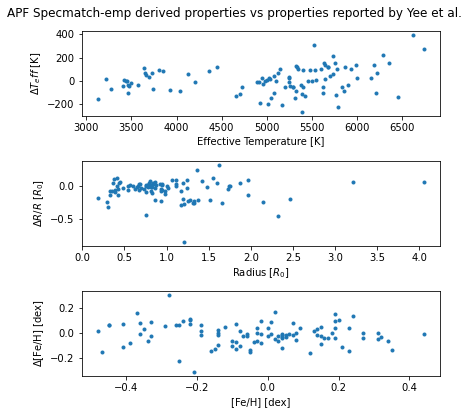

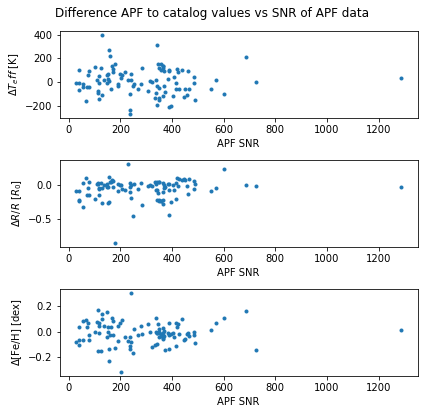

In [16]:
# plot certain properties to compare

SNR_results = pd.read_csv('SNR_results.csv')
SNR_results_sorted = SNR_results.sort_values(by=['HIP_NAME'])
apf_SNR = SNR_results_sorted['SNR']
 
apf_Teff = apf_sorted.iloc[:,1].to_numpy() 
yee_Teff = yee_sorted.iloc[:,1].to_numpy()
apf_R = apf_sorted.iloc[:,3].to_numpy()
yee_R = yee_sorted.iloc[:,3].to_numpy()
apf_feh = apf_sorted.iloc[:,7].to_numpy()
yee_feh = yee_sorted.iloc[:,7].to_numpy()

# remove  38th star (lowest SNR, outlier in being very far from Yee values)
# [NO LONGER RELEVENT]
#apf_Teff = np.append(apf_Teff[0:38],apf_Teff[39:])
#yee_Teff = np.append(yee_Teff[0:38],yee_Teff[39:])
#apf_R = np.append(apf_R[0:38],apf_R[39:])
#yee_R = np.append(yee_R[0:38],yee_R[39:])
#apf_feh = np.append(apf_feh[0:38],apf_feh[39:])
#yee_feh = np.append(yee_feh[0:38],yee_feh[39:])
#apf_SNR = np.append(apf_SNR[0:38],apf_SNR[39:])

# plot difference between APF Specmatch and Yee properties, vs Yee Properties
fig, axs = plt.subplots(3, 1, figsize = (6,6)) 
axs[0].plot(yee_Teff,yee_Teff-apf_Teff,'.') 
axs[0].set_xlabel('Effective Temperature [K]')
axs[0].set_ylabel('$\Delta T_eff$ [K]')
axs[1].plot(yee_R, (yee_R-apf_R)/yee_R,'.')
axs[1].set_xlabel('Radius [$R_0$]')
axs[1].set_ylabel('$\Delta R/ R$ [$R_0$]')
axs[2].plot(yee_feh, yee_feh-apf_feh,'.')
axs[2].set_xlabel('[Fe/H] [dex]')
axs[2].set_ylabel('$\Delta$[Fe/H] [dex]')
fig.suptitle('APF Specmatch-emp derived properties vs properties reported by Yee et al.')
#fig.tight_layout(pad=1.0)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('APF_Yee_comparison.png')

# plot difference between APF Specmatch and Yee properties, vs APF SNR
fig, axs = plt.subplots(3, 1, figsize = (6,6)) 
axs[0].plot(apf_SNR,yee_Teff-apf_Teff,'.') #Is this right to use Yee as the x-axis, 'correct' T value?
axs[0].set_xlabel('APF SNR')
axs[0].set_ylabel('$\Delta T_eff$ [K]')
axs[1].plot(apf_SNR, (yee_R-apf_R)/yee_R,'.') # why normalize to R?
axs[1].set_xlabel('APF SNR')
axs[1].set_ylabel('$\Delta R/ R$ [$R_0$]')
axs[2].plot(apf_SNR, yee_feh-apf_feh,'.')
axs[2].set_xlabel('APF SNR')
axs[2].set_ylabel('$\Delta$[Fe/H] [dex]')
fig.suptitle('Difference APF to catalog values vs SNR of APF data')
#fig.tight_layout(pad=1.0)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('APF_Yee_comparison_SNR.png')

In [ ]:
#  for checking which stars have the greatest differences
def check_differ():
    idxs = []
    for idx in range(len(yee_R)):
        if abs(apf_R[idx] - yee_R[idx])/yee_R[idx] > 1.0: # can change to any useful test
            idxs = idxs + [idx]
    diff = (apf_R - yee_R)/yee_R
    return idxs
check_differ()

In [30]:
# calculate RMS for new results (FIRST RUN ABOVE ON THE DESIRED RESULTS )
def calc_RMS():
    diff = (apf_R - yee_R)/yee_R
    rms_R_new = np.sqrt(np.mean(diff**2)) 
    print('rms_R = ' + str(rms_R_new))

    diff =  (apf_Teff - yee_Teff)
    rms_T_new = np.sqrt(np.mean(diff**2))
    print('rms_Teff = ' + str(rms_T_new))

    diff =  (apf_feh - yee_feh)
    rms_feh_new = np.sqrt(np.mean(diff**2)) 
    print('rms_feh = ' + str(rms_feh_new))

calc_RMS()

rms_R = 0.160491926348313
rms_Teff = 114.33181526280048
rms_feh = 0.09103829027958348


In [33]:
def calc_RMS_at_divisions():
    # To get at division in deltas at T ~ 4500K
    apf_Teff_1 = apf_Teff[yee_Teff < 4500]
    yee_Teff_1 = yee_Teff[yee_Teff < 4500]
    apf_Teff_2 = apf_Teff[yee_Teff >= 4500]
    yee_Teff_2 = yee_Teff[yee_Teff >= 4500]

    apf_R_1 = apf_R[yee_Teff < 4500]
    yee_R_1 = yee_R[yee_Teff < 4500]
    apf_R_2 = apf_R[yee_Teff >= 4500]
    yee_R_2 = yee_R[yee_Teff >= 4500]

    apf_feh_1 = apf_feh[yee_Teff < 4500]
    yee_feh_1 = yee_feh[yee_Teff < 4500]
    apf_feh_2 = apf_feh[yee_Teff >= 4500]
    yee_feh_2 = yee_feh[yee_Teff >= 4500]

    diff = (apf_R_1 - yee_R_1)/yee_R_1
    rms_R_new = np.sqrt(np.mean(diff**2)) 
    print('rms_R for T<4500 = ' + str(rms_R_new))

    diff = (apf_R_2 - yee_R_2)/yee_R_2
    rms_R_new = np.sqrt(np.mean(diff**2)) 
    print('rms_R for T>4500 = ' + str(rms_R_new))

    diff =  (apf_Teff_1 - yee_Teff_1)
    rms_T_new = np.sqrt(np.mean(diff**2))
    print('rms_Teff for T<4500 = ' + str(rms_T_new))

    diff =  (apf_Teff_2 - yee_Teff_2)
    rms_T_new = np.sqrt(np.mean(diff**2))
    print('rms_Teff for T>4500 = ' + str(rms_T_new))

    diff =  (apf_feh_1 - yee_feh_1)
    rms_feh_new = np.sqrt(np.mean(diff**2)) 
    print('rms_feh for T<4500= ' + str(rms_feh_new))

    diff =  (apf_feh_2 - yee_feh_2)
    rms_feh_new = np.sqrt(np.mean(diff**2)) 
    print('rms_feh for T>4500= ' + str(rms_feh_new))
    
    # To get at division in deltas at R ~ 1.0 Ro
    apf_Teff_1 = apf_Teff[yee_R < 1.0]
    yee_Teff_1 = yee_Teff[yee_R < 1.0]
    apf_Teff_2 = apf_Teff[yee_R > 1.0]
    yee_Teff_2 = yee_Teff[yee_R > 1.0]

    apf_R_1 = apf_R[yee_R < 1.0]
    yee_R_1 = yee_R[yee_R < 1.0]
    apf_R_2 = apf_R[yee_R > 1.0]
    yee_R_2 = yee_R[yee_R > 1.0]

    apf_feh_1 = apf_feh[yee_R < 1.0]
    yee_feh_1 = yee_feh[yee_R < 1.0]
    apf_feh_2 = apf_feh[yee_R > 1.0]
    yee_feh_2 = yee_feh[yee_R > 1.0]

    diff = (apf_R_1 - yee_R_1)/yee_R_1
    rms_R_new = np.sqrt(np.mean(diff**2)) 
    print('rms_R for R<1.0 = ' + str(rms_R_new))

    diff = (apf_R_2 - yee_R_2)/yee_R_2
    rms_R_new = np.sqrt(np.mean(diff**2)) 
    print('rms_R for R>1.0 = ' + str(rms_R_new))

    diff =  (apf_Teff_1 - yee_Teff_1)
    rms_T_new = np.sqrt(np.mean(diff**2))
    print('rms_Teff for R<1.0 = ' + str(rms_T_new))

    diff =  (apf_Teff_2 - yee_Teff_2)
    rms_T_new = np.sqrt(np.mean(diff**2))
    print('rms_Teff for R>1.0 = ' + str(rms_T_new))

    diff =  (apf_feh_1 - yee_feh_1)
    rms_feh_new = np.sqrt(np.mean(diff**2)) 
    print('rms_feh for R<1.0 = ' + str(rms_feh_new))

    diff =  (apf_feh_2 - yee_feh_2)
    rms_feh_new = np.sqrt(np.mean(diff**2)) 
    print('rms_feh for R>1.0 = ' + str(rms_feh_new))

calc_RMS_at_divisions()

rms_R for T<4500 = 0.10735169784147
rms_R for T>4500 = 0.1751909220614897
rms_Teff for T<4500 = 71.48467889345241
rms_Teff for T>4500 = 125.82456675233713
rms_feh for T<4500= 0.11078461431638767
rms_feh for T>4500= 0.08310483339333119
rms_R for R<1.0 = 0.10519438646739061
rms_R for R>1.0 = 0.22161645350948111
rms_Teff for R<1.0 = 89.10930622365598
rms_Teff for R>1.0 = 145.70246446176117
rms_feh for R<1.0 = 0.08319089978147619
rms_feh for R>1.0 = 0.10228166239135177


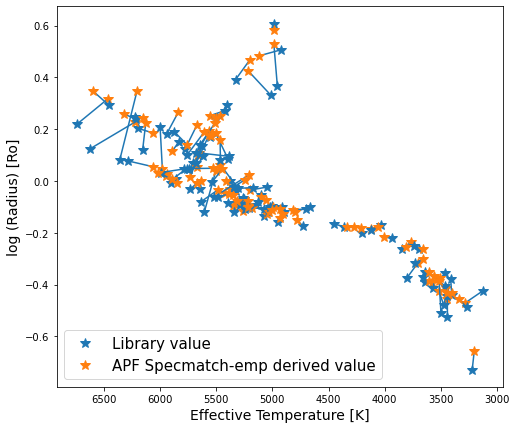

In [92]:
# visualize the difference betwenn library and derived values
all_yee_properties = pd.read_csv('yee_library_full.csv')
all_yee_Teff = all_yee_properties.iloc[:,1]
all_yee_R = all_yee_properties.iloc[:,3] 
plt.figure(figsize = (8,7));
for star in range(len(yee_Teff)):    
    if star == 1:
        labels = ['_nolegend_', 'Library value', 'APF Specmatch-emp derived value']
    else:
        labels = ['_nolegend_', '_nolegend_','_nolegend_']
    plt.plot([yee_Teff[star], apf_Teff[star]], [np.log10(yee_R[star]), np.log10(apf_R[star])],  c='C0',  label=labels[0])
    plt.plot(yee_Teff[star], np.log10(yee_R[star]),'*', markersize = 10, c = 'C0', label = labels[1]) # Just the ones we used
    plt.plot(apf_Teff[star], np.log10(apf_R[star]),'*', markersize = 10, c = 'C1', label = labels[2]) # just the ones we used
plt.gca().invert_xaxis()
plt.ylabel('log (Radius) [Ro]', fontsize = 14)
plt.xlabel('Effective Temperature [K]', fontsize = 14)
plt.legend(fontsize = 15)
